In [1]:
import glob
import os
import cv2
import glob
import importlib
import h5py
import json
import copy
import _pickle as pkl
import numpy as np
import pandas as pd
import seaborn as sns
import pylab as pl

In [2]:
import scipy.stats as spstats
import analyze2p.utils as hutils
import analyze2p.plotting as pplot

import analyze2p.receptive_fields.utils as rfutils
import analyze2p.aggregate_datasets as aggr
import analyze2p.scatter as sct

In [3]:
rootdir = '/n/coxfs01/2p-data'
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'
# Receptive Field settings
traceid='traces001'
response_type='dff'
do_spherical_correction=False
is_neuropil = False

pplot.set_plot_params()
visual_areas, area_colors = pplot.set_threecolor_palette()

In [4]:
sdata, cells0 = aggr.get_aggregate_info(visual_areas=visual_areas, return_cells=True)
# meta['session_int'] = meta['session'].astype(int)

# dsets = meta[(meta.experiment==experiment) & (meta.visual_area==va)
#             & (meta['session_int']>=20190511)].copy()
# dsets

/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 14 dsets


In [5]:
basedir = os.path.join(aggregate_dir, 'receptive-fields', 'scatter')
print(basedir)
if not os.path.exists(basedir):
    os.makedirs(basedir)


/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/scatter


In [473]:

traceid = 'traces001'
response_type='dff'
do_spherical_correction=False

fit_desc = rfutils.get_fit_desc(response_type=response_type,
                               do_spherical_correction=do_spherical_correction)
data_id = '%s|%s' % (traceid, fit_desc)
data_id

'traces001|fit-2dgaus_dff-no-cutoff'

#### Check 1 FOV

In [6]:
basedir

'/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/scatter'

In [7]:
examples_dir = os.path.join(basedir, 'examples')
if not os.path.exists(examples_dir):
    os.makedirs(examples_dir)
    print(examples_dir)

In [8]:
import analyze2p.retinotopy.segment as seg

In [362]:
dk = '20191111_JC120_fov1'
va='Li'
experiment = 'rfs10'


fit_desc = rfutils.get_fit_desc(response_type='dff', do_spherical_correction=False)
# fit_results, fit_params = rfutils.load_fit_results(dk, experiment=experiment,
#                                            fit_desc=fit_desc)
# fitdf_ = rfutils.rfits_to_df(fit_results, fit_params)
# fitdf_.shape

# rfdf_ = fitdf_[fitdf_['r2']>0.5].copy()
# rfdf_['cell'] = rfdf_.index.tolist()

In [363]:
exp

'rfs10'

In [364]:
# Get reliable c
eval_results, eval_params = rfutils.load_eval_results(dk,
                                experiment=experiment, 
                                traceid=traceid, 
                                fit_desc=fit_desc)   
reliable_ = rfutils.get_reliable_fits(eval_results['pass_cis'],
                                    pass_criterion='position')
fitrf_ = sct.get_projected_soma_rfs(dk, va, experiment=experiment, 
                                    traceid=traceid, response_type=response_type,
                                    do_spherical_correction=do_spherical_correction)
bootdata = eval_results['bootdf'].copy()
rois_ = np.intersect1d(reliable_, fitrf_['cell'].unique())
boot_ = bootdata[bootdata['cell'].isin(rois_)]
cis_ = eval_results['cis'].loc[rois_]
rfs_ = fitrf_[fitrf_['cell'].isin(rois_)]
rfs_.index = rfs_['cell'].values

loading vectors
adding pos


In [123]:
%matplotlib notebook

In [365]:
marker='o'
marker_size=5
ci = 0.95
lw=0.5
fill_marker=True
deviant_color='magenta'
scatter_kws={'s': marker_size, 'marker': marker}
line_kws={'lw': lw}

fig, axn = pl.subplots(1, 2, figsize=(7,4), sharex=True)

for ax, cond in zip(axn.flat, ['az', 'el']):
    # Get var names for V1/V2
    if cond=='az':
        ax.set_ylim([0, 50])
    else:
        ax.set_ylim([-20, 30])
#     ax.set_xlim([0, 1200])
    xname = 'ml_proj' if cond=='az' else 'ap_proj'
    yname = 'x0' if cond=='az' else 'y0'
    ax.set_xlim([-10, 1210])
    # Get projected cortical position
    ax, devs_ = sct.fit_with_deviants(boot_, cis_, rfs_, 
                          xname=xname, yname=yname, ax=ax,
                          scatter_kws=scatter_kws, line_kws=line_kws, 
                          deviant_color=deviant_color,lw=lw)
    ax.set_title(cond)
    ylabel='Azimuth' if cond=='az' else 'Elevation'
    ax.set_ylabel('%s location (deg)' % ylabel)
    ax.set_xlabel('Cell center location (um)')
    devdf = pd.DataFrame({'deviants': devs_})
    devdf['cond'] = cond
    
    #currd = df_[df_.axis==cond].copy()
pl.subplots_adjust(left=0.1, right=0.95, bottom=0.2, top=0.85, wspace=0.3)

pplot.label_figure(fig, '%s_%s_%s' % (va, dk, experiment))

# figname = 'deviants_%s_%s_%s' % (dk, va, experiment)
# pl.savefig(os.path.join(examples_dir, '%s.svg' % figname))

<IPython.core.display.Javascript object>

2
y=0.11x + -96.46
2
y=0.39x + -216.06


In [373]:
reliable_

[66, 75]

In [367]:
regr_ = sct.load_models(dk, va)

In [368]:
#### Predict CORTICAL position (from retino position)
p_x = sct.predict_cortex_position(regr_, cond='az', 
                          points=rfs_['x0'].values)
p_y = sct.predict_cortex_position(regr_, cond='el', 
                          points=rfs_['y0'].values)
rfs_.loc[:, 'predicted_ml_proj'] = p_x
rfs_.loc[:, 'predicted_ap_proj'] = p_y

#### Predict RETINO position (from cortical position)
r_x = sct.predict_retino_position(regr_, cond='az', 
                          points=rfs_['ml_proj'].values)
r_y = sct.predict_retino_position(regr_, cond='el', 
                          points=rfs_['ap_proj'].values)
rfs_.loc[:, 'predicted_x0'] = r_x
rfs_.loc[:, 'predicted_y0'] = r_y

rfs_['deg_scatter_x0'] = rfs_['x0'] - rfs_['predicted_x0']
rfs_['deg_scatter_y0'] = rfs_['y0'] - rfs_['predicted_y0']

rfs_['dist_scatter_ml'] = abs(rfs_['ml_proj'] - rfs_['predicted_ml_proj'])
rfs_['dist_scatter_ap'] = abs(rfs_['ap_proj'] - rfs_['predicted_ap_proj'])

/home/julianarhee/anaconda2/envs/rat2p/lib/python3.7/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/home/julianarhee/anaconda2/envs/rat2p/lib/python3.7/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/home/julianarhee/anaconda2/envs/rat2p/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy

In [374]:
rfs_

x0        y0    sigma_x    sigma_y     theta    offset  amplitude  \
66  -1.644652  0.937623  30.707761  37.559167  0.503039 -0.038241   0.320067   
75  20.996492 -9.180793  30.621318  22.591748  6.133987 -0.004863   0.093321   

          r2  cell visual_area  ...      ml_proj     ap_proj  \
66  0.917663    66          Li  ...   858.505901  555.381958   
75  0.698990    75          Li  ...  1063.518616  529.485184   

   predicted_ml_proj predicted_ap_proj predicted_x0  predicted_y0  \
66        854.666393        706.885268    -1.351554     -4.621748   
75       1151.259489        431.139406    14.298583     -5.572022   

    deg_scatter_x0  deg_scatter_y0  dist_scatter_ml  dist_scatter_ap  
66       -0.293098        5.559371         3.839509       151.503310  
75        6.697909       -3.608770        87.740872        98.345779  

[2 rows x 31 columns]

In [370]:
%matplotlib notebook

<IPython.core.display.Javascript object>


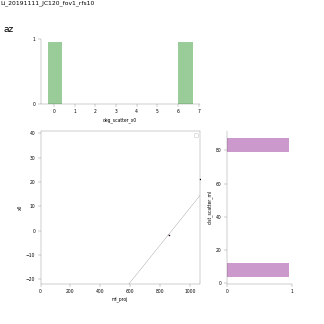

No handles with labels found to put in legend.


<IPython.core.display.Javascript object>


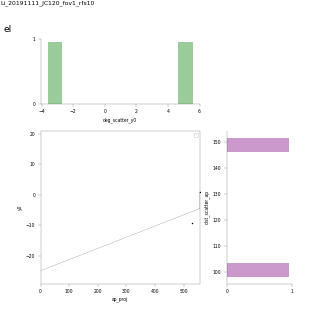

No handles with labels found to put in legend.


In [371]:
sz = 3
lw=0.5
nbins=10
color1='purple'
color2='green'

for cond in ['az', 'el']:
    fig = sct.plot_scatter_and_marginals(rfs_, regr_, cond=cond)
    pplot.label_figure(fig, '%s_%s_%s' % (va, dk, experiment))
    fig.text(0.01, 0.9, '%s' % cond, fontsize=12)
    
    figname = 'scatter_marginals_%s__%s_%s_%s' % (cond, dk, va, experiment)
    #pl.savefig(os.path.join(examples_dir, '%s.svg' % figname))

In [28]:
# dev_fpath = os.path.join(eval_params['rfdir'], 'evaluation', 'deviants.json')
# with open(dev_fpath, 'w') as f:
#     json.dump(deviants, f, indent=4)

In [117]:
importlib.reload(sct)

<module 'analyze2p.scatter' from '/home/julianarhee/Repositories/rat-2p-area-characterizations/analyze2p/scatter.py'>

    identifying deviants (20190512_JC083_fov1, Lm)
loading vectors


Traceback (most recent call last):
  File "/home/julianarhee/Repositories/rat-2p-area-characterizations/analyze2p/scatter.py", line 1021, in load_vectors
    with open(gradients_fpath, 'rb') as f:
FileNotFoundError: [Errno 2] No such file or directory: '/n/coxfs01/2p-data/JC083/20190512/FOV1_zoom2p0x/segmentation/gradient_vectors.pkl'


adding pos


<IPython.core.display.Javascript object>


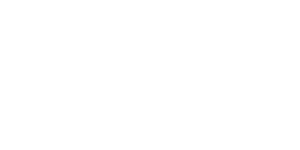

<IPython.core.display.Javascript object>


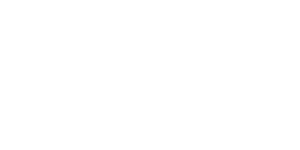

44
y=0.04x + 57.61


<IPython.core.display.Javascript object>


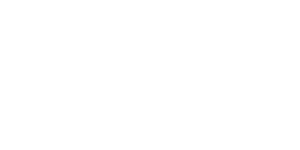

<IPython.core.display.Javascript object>


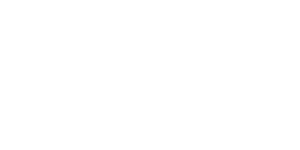

44
y=0.04x + 57.61
    identifying deviants (20190513_JC078_fov1, Lm)
loading vectors


Traceback (most recent call last):
  File "/home/julianarhee/Repositories/rat-2p-area-characterizations/analyze2p/scatter.py", line 1021, in load_vectors
    with open(gradients_fpath, 'rb') as f:
FileNotFoundError: [Errno 2] No such file or directory: '/n/coxfs01/2p-data/JC078/20190513/FOV1_zoom2p0x/segmentation/gradient_vectors.pkl'


adding pos


<IPython.core.display.Javascript object>


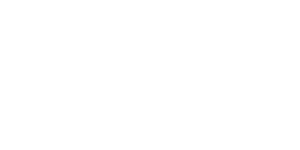

<IPython.core.display.Javascript object>


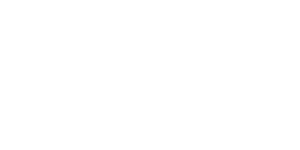

21
y=0.06x + 51.68


<IPython.core.display.Javascript object>


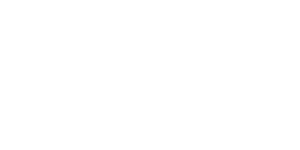

<IPython.core.display.Javascript object>


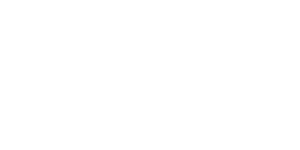

21
y=0.06x + 51.68
    identifying deviants (20190517_JC083_fov1, Lm)
loading vectors


Traceback (most recent call last):
  File "/home/julianarhee/Repositories/rat-2p-area-characterizations/analyze2p/scatter.py", line 1021, in load_vectors
    with open(gradients_fpath, 'rb') as f:
FileNotFoundError: [Errno 2] No such file or directory: '/n/coxfs01/2p-data/JC083/20190517/FOV1_zoom2p0x/segmentation/gradient_vectors.pkl'


adding pos


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


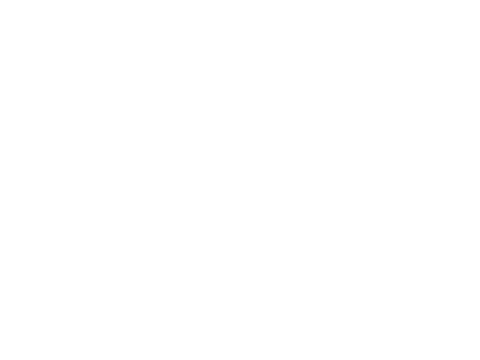

22
y=0.05x + 60.80


<IPython.core.display.Javascript object>


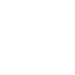

<IPython.core.display.Javascript object>


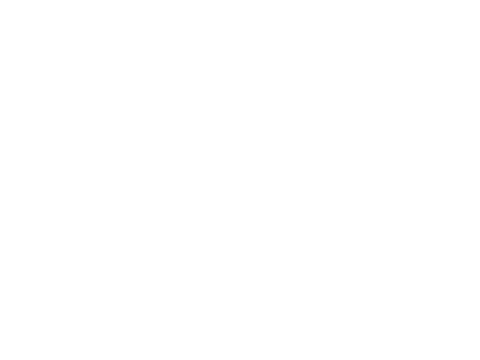

22
y=0.05x + 60.80
    identifying deviants (20190525_JC084_fov1, Lm)
loading vectors


Traceback (most recent call last):
  File "/home/julianarhee/Repositories/rat-2p-area-characterizations/analyze2p/scatter.py", line 1021, in load_vectors
    with open(gradients_fpath, 'rb') as f:
FileNotFoundError: [Errno 2] No such file or directory: '/n/coxfs01/2p-data/JC084/20190525/FOV1_zoom2p0x/segmentation/gradient_vectors.pkl'


adding pos


<IPython.core.display.Javascript object>


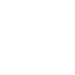

<IPython.core.display.Javascript object>


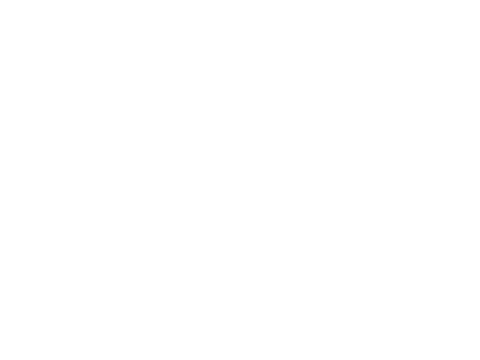

33
y=0.04x + 35.99


<IPython.core.display.Javascript object>


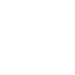

<IPython.core.display.Javascript object>


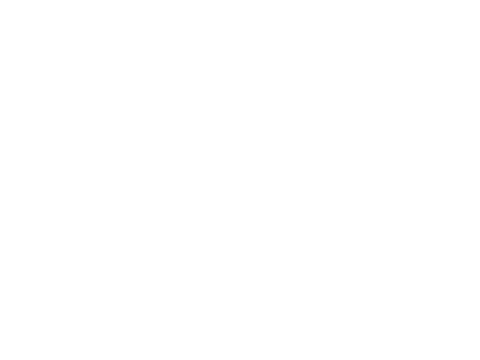

33
y=0.04x + 35.99
    identifying deviants (20190602_JC080_fov2, Lm)
loading vectors


Traceback (most recent call last):
  File "/home/julianarhee/Repositories/rat-2p-area-characterizations/analyze2p/scatter.py", line 1021, in load_vectors
    with open(gradients_fpath, 'rb') as f:
FileNotFoundError: [Errno 2] No such file or directory: '/n/coxfs01/2p-data/JC080/20190602/FOV2_zoom2p0x/segmentation/gradient_vectors.pkl'


adding pos


<IPython.core.display.Javascript object>


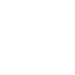

<IPython.core.display.Javascript object>


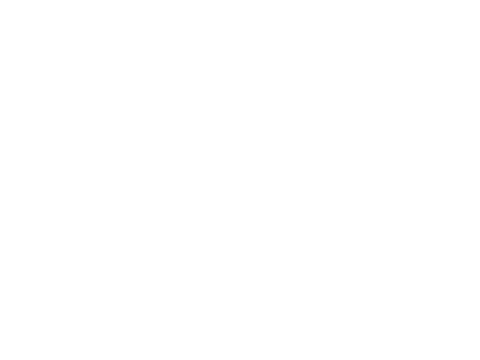

34
y=0.04x + 32.75


<IPython.core.display.Javascript object>


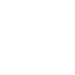

<IPython.core.display.Javascript object>


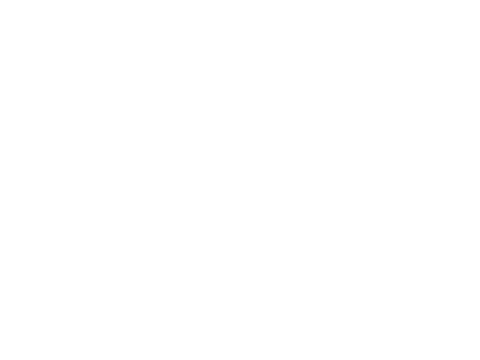

34
y=0.04x + 32.75
    identifying deviants (20190603_JC080_fov1, Lm)
loading vectors


Traceback (most recent call last):
  File "/home/julianarhee/Repositories/rat-2p-area-characterizations/analyze2p/scatter.py", line 1021, in load_vectors
    with open(gradients_fpath, 'rb') as f:
FileNotFoundError: [Errno 2] No such file or directory: '/n/coxfs01/2p-data/JC080/20190603/FOV1_zoom2p0x/segmentation/gradient_vectors.pkl'


adding pos


<IPython.core.display.Javascript object>


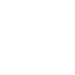

<IPython.core.display.Javascript object>


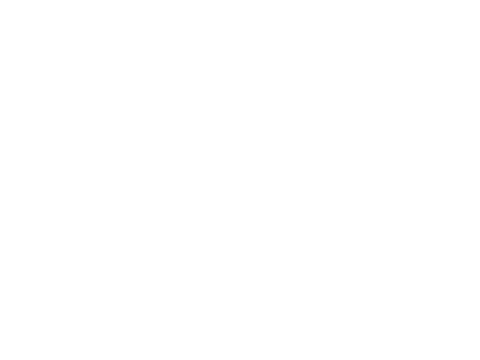

55
y=0.07x + 67.56


<IPython.core.display.Javascript object>


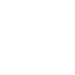

<IPython.core.display.Javascript object>


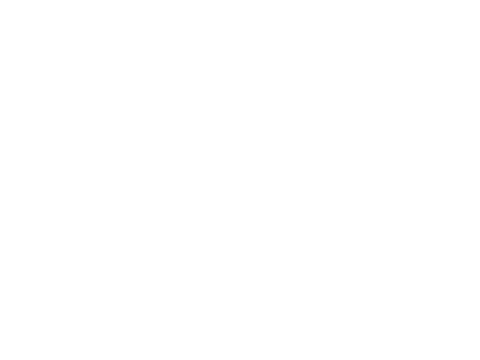

55
y=0.07x + 67.56
    identifying deviants (20190618_JC097_fov1, Lm)
loading vectors


Traceback (most recent call last):
  File "/home/julianarhee/Repositories/rat-2p-area-characterizations/analyze2p/scatter.py", line 1021, in load_vectors
    with open(gradients_fpath, 'rb') as f:
FileNotFoundError: [Errno 2] No such file or directory: '/n/coxfs01/2p-data/JC097/20190618/FOV1_zoom2p0x/segmentation/gradient_vectors.pkl'


adding pos


<IPython.core.display.Javascript object>


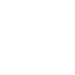

<IPython.core.display.Javascript object>


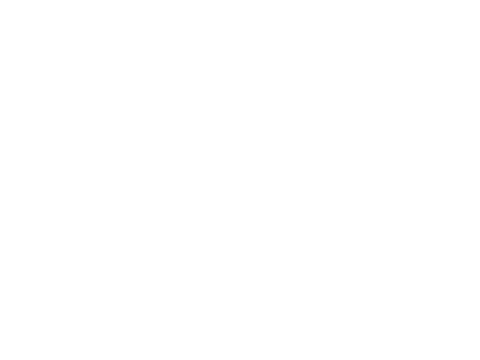

11
y=0.05x + 53.72


<IPython.core.display.Javascript object>


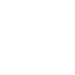

<IPython.core.display.Javascript object>


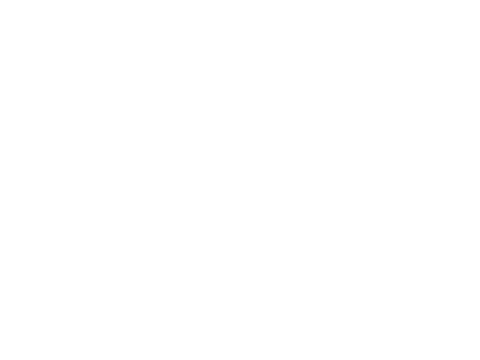

11
y=0.05x + 53.72
    identifying deviants (20190618_JC097_fov1, Lm)
loading vectors
adding pos


<IPython.core.display.Javascript object>


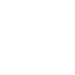

<IPython.core.display.Javascript object>


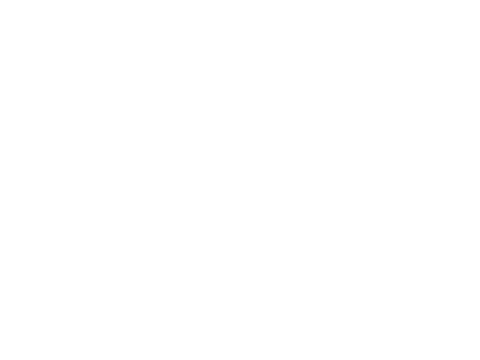

26
y=0.02x + 35.77


<IPython.core.display.Javascript object>


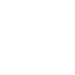

<IPython.core.display.Javascript object>


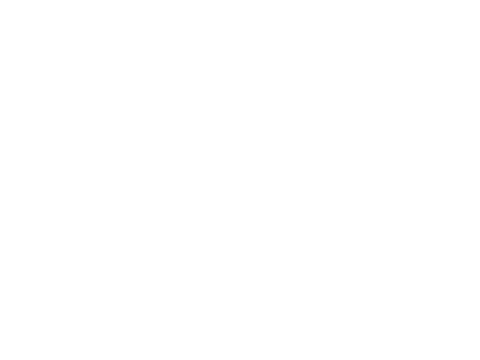

26
y=0.02x + 35.77
    identifying deviants (20190627_JC091_fov1, Lm)
loading vectors


Traceback (most recent call last):
  File "/home/julianarhee/Repositories/rat-2p-area-characterizations/analyze2p/scatter.py", line 1021, in load_vectors
    with open(gradients_fpath, 'rb') as f:
FileNotFoundError: [Errno 2] No such file or directory: '/n/coxfs01/2p-data/JC091/20190627/FOV1_zoom2p0x/segmentation/gradient_vectors.pkl'


adding pos


<IPython.core.display.Javascript object>


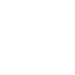

<IPython.core.display.Javascript object>


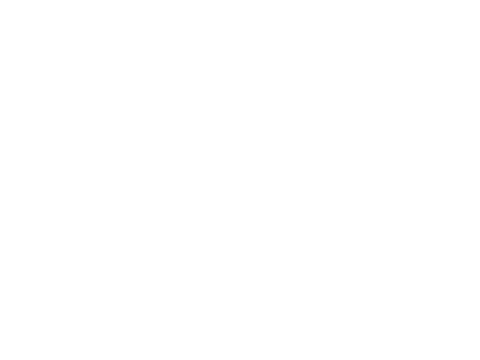

8
y=0.08x + 49.08


<IPython.core.display.Javascript object>


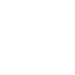

<IPython.core.display.Javascript object>


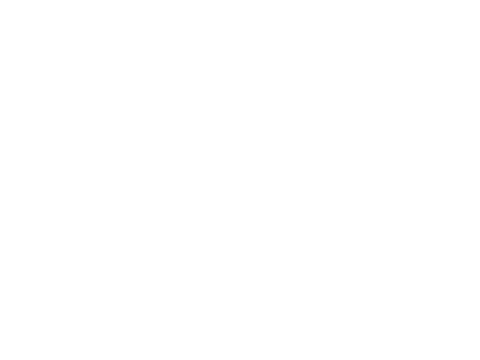

8
y=0.08x + 49.08
    identifying deviants (20191111_JC117_fov1, Lm)
loading vectors


Traceback (most recent call last):
  File "/home/julianarhee/Repositories/rat-2p-area-characterizations/analyze2p/scatter.py", line 1021, in load_vectors
    with open(gradients_fpath, 'rb') as f:
FileNotFoundError: [Errno 2] No such file or directory: '/n/coxfs01/2p-data/JC117/20191111/FOV1_zoom2p0x/segmentation/gradient_vectors.pkl'


adding pos


<IPython.core.display.Javascript object>


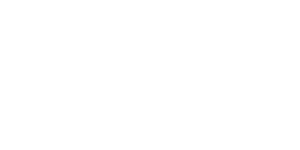

<IPython.core.display.Javascript object>


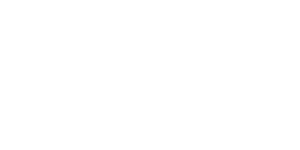

18
y=-0.00x + 34.64


<IPython.core.display.Javascript object>


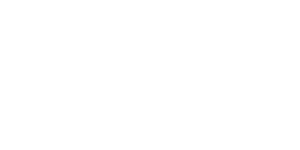

<IPython.core.display.Javascript object>


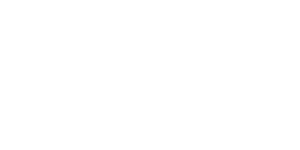

18
y=-0.00x + 34.64
    identifying deviants (20191111_JC117_fov2, Lm)
loading vectors


Traceback (most recent call last):
  File "/home/julianarhee/Repositories/rat-2p-area-characterizations/analyze2p/scatter.py", line 1021, in load_vectors
    with open(gradients_fpath, 'rb') as f:
FileNotFoundError: [Errno 2] No such file or directory: '/n/coxfs01/2p-data/JC117/20191111/FOV2_zoom2p0x/segmentation/gradient_vectors.pkl'


adding pos


<IPython.core.display.Javascript object>


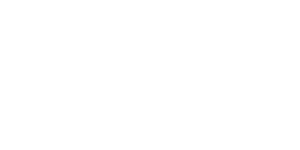

<IPython.core.display.Javascript object>


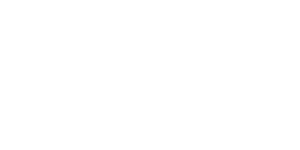

2
y=0.03x + 45.07


<IPython.core.display.Javascript object>


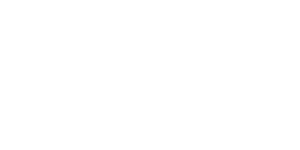

<IPython.core.display.Javascript object>


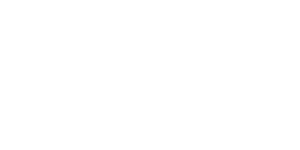

2
y=0.03x + 45.07
    identifying deviants (20190511_JC083_fov1, V1)
loading vectors


Traceback (most recent call last):
  File "/home/julianarhee/Repositories/rat-2p-area-characterizations/analyze2p/scatter.py", line 1021, in load_vectors
    with open(gradients_fpath, 'rb') as f:
FileNotFoundError: [Errno 2] No such file or directory: '/n/coxfs01/2p-data/JC083/20190511/FOV1_zoom2p0x/segmentation/gradient_vectors.pkl'


adding pos


<IPython.core.display.Javascript object>


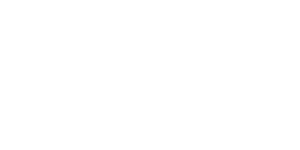

<IPython.core.display.Javascript object>


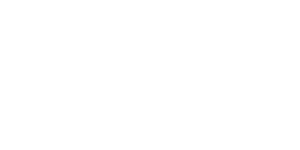

42
y=0.03x + -0.18


<IPython.core.display.Javascript object>


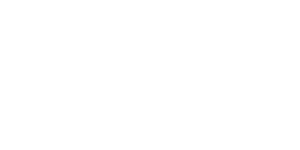

<IPython.core.display.Javascript object>


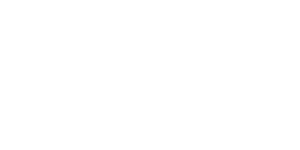

42
y=0.03x + -0.18
    identifying deviants (20190522_JC084_fov1, V1)
loading vectors


Traceback (most recent call last):
  File "/home/julianarhee/Repositories/rat-2p-area-characterizations/analyze2p/scatter.py", line 1021, in load_vectors
    with open(gradients_fpath, 'rb') as f:
FileNotFoundError: [Errno 2] No such file or directory: '/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/segmentation/gradient_vectors.pkl'


adding pos


<IPython.core.display.Javascript object>


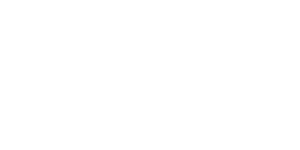

<IPython.core.display.Javascript object>


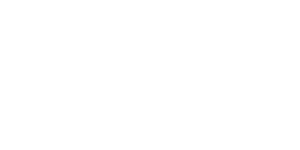

127
y=0.02x + 4.65


<IPython.core.display.Javascript object>


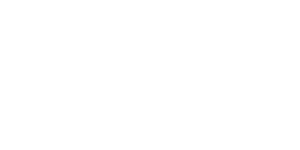

<IPython.core.display.Javascript object>


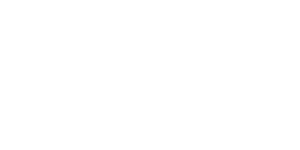

127
y=0.02x + 4.65
    identifying deviants (20190613_JC097_fov1, V1)
loading vectors


Traceback (most recent call last):
  File "/home/julianarhee/Repositories/rat-2p-area-characterizations/analyze2p/scatter.py", line 1021, in load_vectors
    with open(gradients_fpath, 'rb') as f:
FileNotFoundError: [Errno 2] No such file or directory: '/n/coxfs01/2p-data/JC097/20190613/FOV1_zoom2p0x/segmentation/gradient_vectors.pkl'


adding pos


<IPython.core.display.Javascript object>


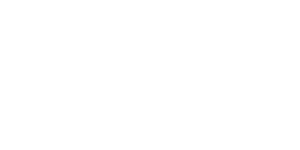

<IPython.core.display.Javascript object>


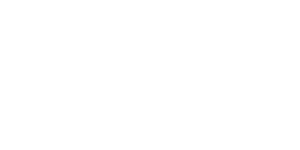

65
y=0.03x + 13.47


<IPython.core.display.Javascript object>


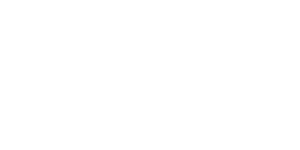

<IPython.core.display.Javascript object>


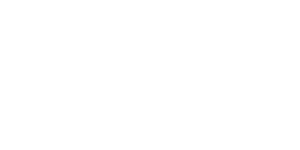

65
y=0.03x + 13.47
    identifying deviants (20190613_JC097_fov1, V1)
loading vectors
adding pos


<IPython.core.display.Javascript object>


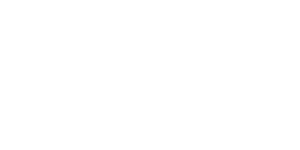

<IPython.core.display.Javascript object>


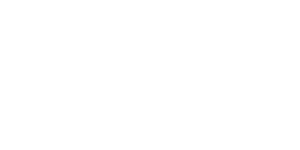

102
y=0.02x + 16.19


<IPython.core.display.Javascript object>


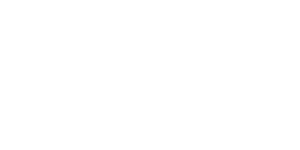

<IPython.core.display.Javascript object>


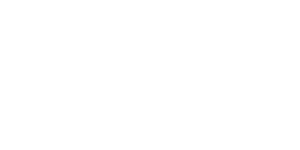

102
y=0.02x + 16.19
    identifying deviants (20190615_JC097_fov2, V1)
loading vectors


Traceback (most recent call last):
  File "/home/julianarhee/Repositories/rat-2p-area-characterizations/analyze2p/scatter.py", line 1021, in load_vectors
    with open(gradients_fpath, 'rb') as f:
FileNotFoundError: [Errno 2] No such file or directory: '/n/coxfs01/2p-data/JC097/20190615/FOV2_zoom2p0x/segmentation/gradient_vectors.pkl'


adding pos


<IPython.core.display.Javascript object>


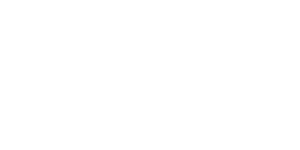

<IPython.core.display.Javascript object>


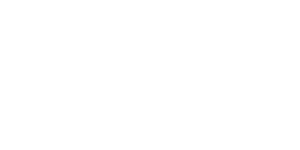

111
y=0.02x + 16.45


<IPython.core.display.Javascript object>


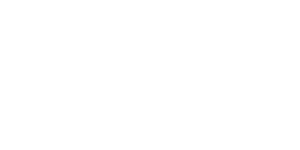

<IPython.core.display.Javascript object>


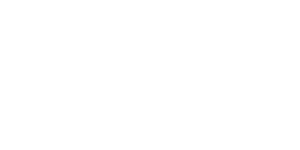

111
y=0.02x + 16.45
    identifying deviants (20190616_JC097_fov1, V1)
loading vectors


Traceback (most recent call last):
  File "/home/julianarhee/Repositories/rat-2p-area-characterizations/analyze2p/scatter.py", line 1021, in load_vectors
    with open(gradients_fpath, 'rb') as f:
FileNotFoundError: [Errno 2] No such file or directory: '/n/coxfs01/2p-data/JC097/20190616/FOV1_zoom2p0x/segmentation/gradient_vectors.pkl'


adding pos


<IPython.core.display.Javascript object>


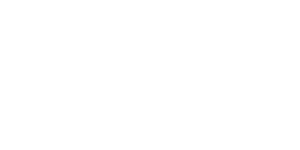

<IPython.core.display.Javascript object>


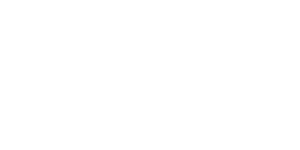

94
y=0.02x + 19.79


<IPython.core.display.Javascript object>


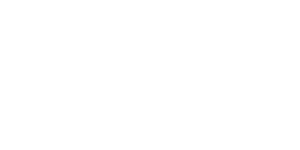

<IPython.core.display.Javascript object>


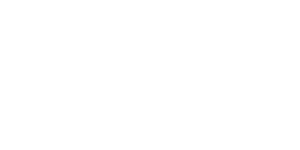

94
y=0.02x + 19.79
    identifying deviants (20190616_JC097_fov1, V1)
loading vectors
adding pos


<IPython.core.display.Javascript object>


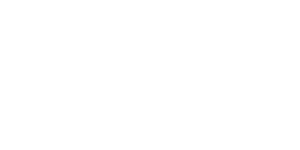

<IPython.core.display.Javascript object>


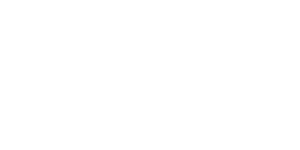

113
y=0.01x + 22.76


<IPython.core.display.Javascript object>


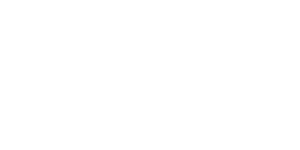

<IPython.core.display.Javascript object>


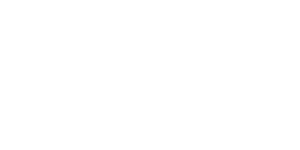

113
y=0.01x + 22.76
    identifying deviants (20190622_JC085_fov1, V1)
loading vectors


Traceback (most recent call last):
  File "/home/julianarhee/Repositories/rat-2p-area-characterizations/analyze2p/scatter.py", line 1021, in load_vectors
    with open(gradients_fpath, 'rb') as f:
FileNotFoundError: [Errno 2] No such file or directory: '/n/coxfs01/2p-data/JC085/20190622/FOV1_zoom2p0x/segmentation/gradient_vectors.pkl'


adding pos


<IPython.core.display.Javascript object>


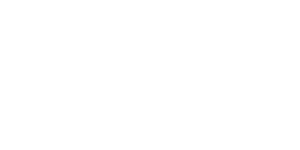

<IPython.core.display.Javascript object>


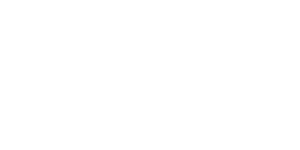

26
y=0.02x + 22.83


<IPython.core.display.Javascript object>


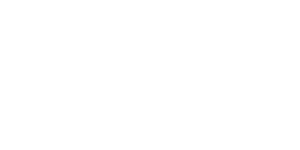

<IPython.core.display.Javascript object>


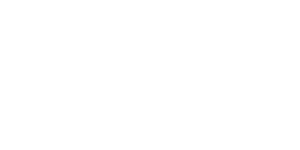

26
y=0.02x + 22.83
    identifying deviants (20190622_JC085_fov1, V1)
loading vectors
adding pos


<IPython.core.display.Javascript object>


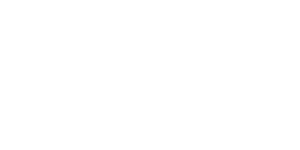

<IPython.core.display.Javascript object>


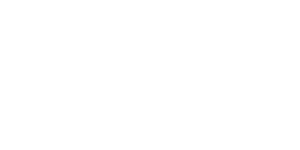

97
y=0.02x + 23.27


<IPython.core.display.Javascript object>


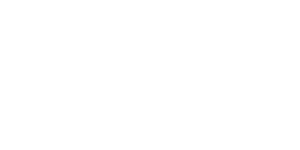

<IPython.core.display.Javascript object>


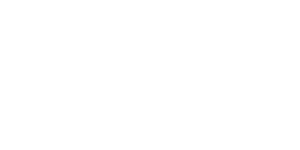

97
y=0.02x + 23.27
    identifying deviants (20191004_JC110_fov2, V1)
loading vectors


Traceback (most recent call last):
  File "/home/julianarhee/Repositories/rat-2p-area-characterizations/analyze2p/scatter.py", line 1021, in load_vectors
    with open(gradients_fpath, 'rb') as f:
FileNotFoundError: [Errno 2] No such file or directory: '/n/coxfs01/2p-data/JC110/20191004/FOV2_zoom2p0x/segmentation/gradient_vectors.pkl'


adding pos


<IPython.core.display.Javascript object>


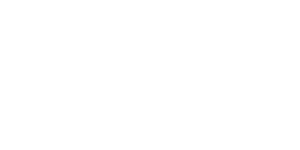

<IPython.core.display.Javascript object>


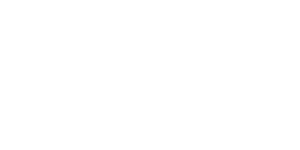

69
y=0.03x + 14.17


<IPython.core.display.Javascript object>


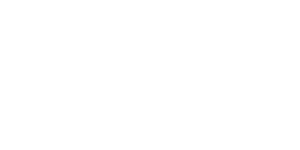

<IPython.core.display.Javascript object>


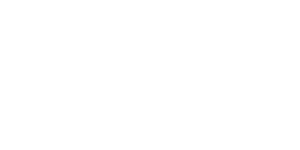

69
y=0.03x + 14.17
    identifying deviants (20191006_JC110_fov1, V1)
loading vectors


Traceback (most recent call last):
  File "/home/julianarhee/Repositories/rat-2p-area-characterizations/analyze2p/scatter.py", line 1021, in load_vectors
    with open(gradients_fpath, 'rb') as f:
FileNotFoundError: [Errno 2] No such file or directory: '/n/coxfs01/2p-data/JC110/20191006/FOV1_zoom2p0x/segmentation/gradient_vectors.pkl'


adding pos


<IPython.core.display.Javascript object>


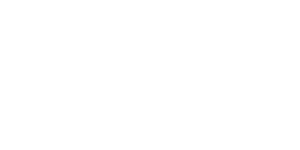

<IPython.core.display.Javascript object>


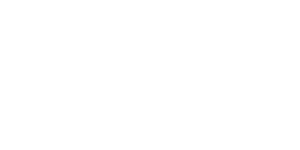

50
y=0.02x + 18.68


<IPython.core.display.Javascript object>


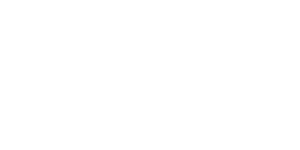

<IPython.core.display.Javascript object>


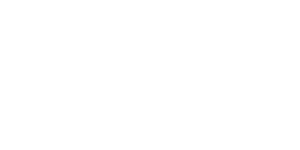

50
y=0.02x + 18.68
    identifying deviants (20191006_JC110_fov1, V1)
loading vectors
adding pos


<IPython.core.display.Javascript object>


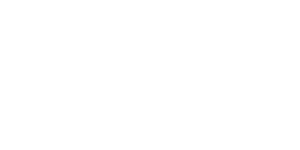

<IPython.core.display.Javascript object>


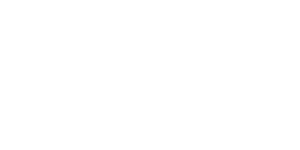

73
y=0.02x + 17.34


<IPython.core.display.Javascript object>


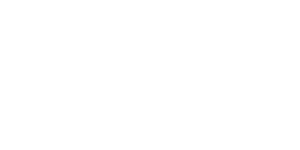

<IPython.core.display.Javascript object>


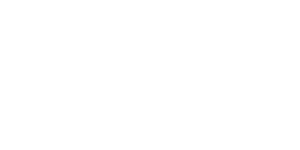

73
y=0.02x + 17.34


In [140]:
d_=[]
no_results=[]
for (va, dk, exp), g in meta.groupby(['visual_area', 'datakey', 'experiment']):
    df_ = sct.get_deviants(dk, va, experiment=exp, traceid=traceid,
                           response_type=response_type,
                           do_spherical_correction=do_spherical_correction)
    if df_ is None:
        no_results.append((va, dk, exp))
        continue
    df_['visual_area'] = va
    df_['datakey'] = dk
    df_['experiment'] = exp
    d_.append(df_)
    

In [153]:
deviants = pd.concat(d_, axis=0)


In [376]:
deviants[deviants.datakey==dk]

deviants cond visual_area              datakey experiment
0       NaN   az          Li  20191111_JC120_fov1      rfs10
1       NaN   el          Li  20191111_JC120_fov1      rfs10
0       NaN   az          Lm  20191111_JC120_fov1      rfs10
1       NaN   el          Lm  20191111_JC120_fov1      rfs10

In [154]:
aggr_deviants = os.path.join(basedir, 'deviants__%s.pkl' % fit_desc)
with open(aggr_deviants, 'wb') as f:
    pkl.dump(deviants, f, protocol=2)
    

In [150]:
deviants[(deviants.datakey=='20190525_JC084_fov1')].groupby(['cond']).count()

deviants  visual_area  datakey  experiment
cond                                            
az           9            9        9           9
el          10           10       10          10

In [139]:
deviants

deviants cond visual_area              datakey experiment
0        NaN   az          Li  20190522_JC089_fov1        rfs
1        NaN   el          Li  20190522_JC089_fov1        rfs
0       99.0   el          Li  20190522_JC089_fov1      rfs10
0       21.0   az          Li  20190527_JC092_fov3      rfs10
1       41.0   az          Li  20190527_JC092_fov3      rfs10
..       ...  ...         ...                  ...        ...
1       23.0   el          Li  20191106_JC120_fov1      rfs10
2       54.0   el          Li  20191106_JC120_fov1      rfs10
3       68.0   el          Li  20191106_JC120_fov1      rfs10
0        NaN   az          Li  20191111_JC120_fov1      rfs10
1        NaN   el          Li  20191111_JC120_fov1      rfs10

[466 rows x 5 columns]

# Load all results from scatter analysis

In [29]:
# va='V1'
# dk = '20190617_JC097_fov1'

# df_ = sct.load_results(dk, va)
meta = sdata[sdata.experiment.isin(['rfs', 'rfs10'])].copy()

In [425]:
missing=[]
d_list=[]
no_eval=[]
for (va, dk, exp), g in meta.groupby(['visual_area', 'datakey', 'experiment']):
    df_ = sct.load_results(dk, va, exp, verbose=False)
    if df_ is None:
        missing.append((va, dk, exp))
        continue
    # get reliable or not
    eval_results, eval_params = rfutils.load_eval_results(dk,
                                    experiment=exp, 
                                    traceid=traceid, 
                                    fit_desc=fit_desc)   
    if eval_results is None:
        no_eval.append((dk, va, exp))
        continue
    reliable_ = rfutils.get_reliable_fits(eval_results['pass_cis'],
                                        pass_criterion='position')
    found_rois = df_['cell'].unique()
    df_['reliable'] = False
    df_.loc[df_['cell'].isin(reliable_), 'reliable'] = True
    
    # Get deviant or not
#     deviants = sct.get_deviants(dk, va, experiment=exp, traceid=traceid,
#                                response_type=response_type,
#                                do_spherical_correction=do_spherical_correction)
    curr_deviants = deviants[(deviants.visual_area==va) & (deviants.datakey==dk)].copy()
    df_['deviant'] = False
    if len(curr_deviants)==0: # is None:
        no_deviants.append((dk, va, exp))
        continue
    for dev_cond, dev_vals in curr_deviants.groupby(['cond']):
        dev_rois = dev_vals['deviants'].values
        df_.loc[(df_.axis==dev_cond) & (df_['cell'].isin(dev_rois)), 'deviant'] = True
        
    df_['visual_area'] = va
    df_['datakey'] = dk
    df_['experiment'] = exp
    d_list.append(df_)
df = pd.concat(d_list, axis=0)
df.shape

(4706, 9)

In [426]:
dk = '20191111_JC120_fov1'
df[df.datakey==dk]

cell  deg_scatter  dist_scatter axis  reliable  deviant visual_area  \
0    66     0.293098      3.839509   az      True    False          Li   
1    75     6.697909     87.740872   az      True    False          Li   
2    84    33.910835    444.223115   az     False    False          Li   
3   183     0.586191      7.678952   az     False    False          Li   
4    66     5.559371    151.503310   el      True    False          Li   
5    75     3.608770     98.345779   el      True    False          Li   
6    84    15.087968    411.175500   el     False    False          Li   
7   183     4.541466    123.763496   el     False    False          Li   
0    66     5.433322    609.456193   az      True    False          Lm   
1    75    17.477315   1960.431778   az      True    False          Lm   
2    84    44.634491   5006.654171   az     False    False          Lm   
3   183    10.384526   1164.833011   az     False    False          Lm   
4    66     6.470278    199.713305   el      True    False          Lm   
5    75     4.809608    148.454622   el      True    False          Lm   
6    84    17.699492    546.317190   el     False    False          Lm   
7   183     4.093040    126.336862   el     False    False          Lm   

               datakey experiment  
0  20191111_JC120_fov1      rfs10  
1  20191111_JC120_fov1      rfs10  
2  20191111_JC120_fov1      rfs10  
3  20191111_JC120_fov1      rfs10  
4  20191111_JC120_fov1      rfs10  
5  20191111_JC120_fov1      rfs10  
6  20191111_JC120_fov1      rfs10  
7  20191111_JC120_fov1      rfs10  
0  20191111_JC120_fov1      rfs10  
1  20191111_JC120_fov1      rfs10  
2  20191111_JC120_fov1      rfs10  
3  20191111_JC120_fov1      rfs10  
4  20191111_JC120_fov1      rfs10  
5  20191111_JC120_fov1      rfs10  
6  20191111_JC120_fov1      rfs10  
7  20191111_JC120_fov1      rfs10

In [427]:
counts = df[['visual_area', 'datakey', 'experiment', 'cell']]\
        .drop_duplicates().groupby(['visual_area', 'datakey', 'experiment'])\
        .count().reset_index().rename(columns={'cell': 'fit'})
rel_ = df[df['reliable']][['visual_area', 'datakey', 'experiment', 'cell']]\
        .drop_duplicates().groupby(['visual_area', 'datakey', 'experiment'])\
        .count().reset_index().rename(columns={'cell': 'reliable'})
dev_ = df[df['deviant']][['visual_area', 'datakey', 'experiment', 'cell']]\
        .drop_duplicates().groupby(['visual_area', 'datakey', 'experiment'])\
        .count().reset_index().rename(columns={'cell': 'deviant'})
print(counts.shape, rel_.shape,dev_.shape)

(48, 4) (48, 4) (43, 4)


In [428]:
add_these = [(va, dk) for (va, dk) in counts[['visual_area', 'datakey']].values
  if dev_.query('@va==visual_area and @dk==datakey').empty] #rel_.head()
print(add_these)
# cols =['visual_area', 'datakey', 'experiment', 'cell']
# for (va, dk) in add_these:
#     dev_.loc[len(dev_), cols] = [va, dk, exp, 0]

countdf0 = pd.merge(counts, rel_)
countdf = pd.merge(countdf0, dev_)

[('Li', '20191012_JC113_fov1'), ('Li', '20191018_JC113_fov1'), ('Li', '20191111_JC120_fov1'), ('Lm', '20191111_JC117_fov2'), ('Lm', '20191111_JC120_fov1')]


In [429]:
%matplotlib notebook

In [430]:
countdf['fraction_reliable'] = countdf['reliable']/countdf['fit'].astype(float)
countdf['fraction_deviant'] = countdf['deviant']/countdf['fit'].astype(float)


In [474]:
fig, ax = pl.subplots()
fig.set_facecolor('1')
exp_colors = {'rfs': [0.7]*3, 'rfs10': [0.4]*3}
sns.stripplot(x='visual_area', y='fraction_deviant', hue='experiment', data=countdf, ax=ax,
             dodge=True, order=visual_areas)
sns.barplot(x='visual_area', y='fraction_deviant', hue='experiment', data=countdf, ax=ax,
             palette=exp_colors, order=visual_areas)

<IPython.core.display.Javascript object>

<AxesSubplot:xlabel='visual_area', ylabel='fraction_deviant'>

## Load REGR for retino gradients

In [432]:
bw_colors=dict((v, [0.7]*3) for v in visual_areas)
axis_colors={'az': [0.7]*3,
             'el': [0.5]*3}

In [433]:
r_=[]
for (va, dk), g in meta.groupby(['visual_area', 'datakey']):
    regr_ = sct.load_models(dk, va)
    regr_['visual_area'] = va
    regr_['datakey'] = dk
    r_.append(regr_)
REGR = pd.concat(r_, axis=0)

In [434]:
pass_regr = REGR[REGR['R2']>0.5].copy()
REGR.shape, pass_regr.shape

((108, 9), (71, 9))

In [435]:
r2_thr=0.5
pass_regr = pd.concat([r for (va, dk), r in REGR.groupby(['visual_area', 'datakey'])\
                       if (round(r[r.cond=='az']['R2'].values[0], 1)>=r2_thr) 
                       and (round(r[r.cond=='el']['R2'].values[0], 1)>=r2_thr)])

In [436]:
pass_regr[['visual_area', 'datakey']].drop_duplicates()['visual_area'].value_counts()

V1    15
Lm    10
Li     6
Name: visual_area, dtype: int64

#### Only include dataset if gradient was well-fit

In [437]:
passdf = pd.concat([g for (va, dk), g in df[df['reliable']]\
                    .groupby(['visual_area', 'datakey'])\
           if not pass_regr.query('@va==visual_area and @dk==datakey').empty])\
            .reset_index(drop=True)

In [438]:
df.head()

cell  deg_scatter  dist_scatter axis  reliable  deviant visual_area  \
0    85     4.075594    292.576006   az      True    False          Li   
1    89    19.672335   1412.224540   az      True    False          Li   
2    99    29.563940   2122.316453   az      True    False          Li   
3   115     0.440748     31.640139   az      True    False          Li   
4   121    16.514193   1185.509887   az     False    False          Li   

               datakey experiment  
0  20190522_JC089_fov1        rfs  
1  20190522_JC089_fov1        rfs  
2  20190522_JC089_fov1        rfs  
3  20190522_JC089_fov1        rfs  
4  20190522_JC089_fov1        rfs

#### 1 expeeriment per fov only

In [475]:
passdf['n_cells'] = None
f_=[]
for (va, dk), g in passdf.groupby(['visual_area', 'datakey']):
    if va=='Lm' and dk in['20190430_JC078_fov1', '20190508_JC083_fov1']:
        continue
    if va in ['V1', 'Lm']:
        if 'rfs' in g['experiment'].values:
            df_ = g[g.experiment=='rfs'].copy()
        elif 'rfs10' in g['experiment'].values:
            df_ = g[g.experiment=='rfs10'].copy()
    elif va=='Li':
        if 'rfs10' in g['experiment'].values:
            df_ = g[g.experiment=='rfs10'].copy()
        elif 'rfs' in g['experiment'].values:
            df_ = g[g.experiment=='rfs'].copy()
    df_['n_cells'] = len(g['cell'].unique())
    # passdf.loc[g.index, 'n_cells'] = len(g['cell'].unique())
    f_.append(df_)
finaldf0 = pd.concat(f_, axis=0)

In [440]:
min_ncells = 10

In [476]:
passdf['n_cells'] = None
for (va, dk,exp), g in passdf.groupby(['visual_area', 'datakey', 'experiment']):
    passdf.loc[g.index, 'n_cells'] = len(g['cell'].unique())
DF = finaldf0[finaldf0['n_cells']>min_ncells]

In [477]:
dk = '20191111_JC120_fov1'
# DF[DF.datakey==dk]
passdf[passdf.datakey==dk]

cell  deg_scatter  dist_scatter axis  reliable  deviant visual_area  \
322    66     0.293098      3.839509   az      True    False          Li   
323    75     6.697909     87.740872   az      True    False          Li   
324    66     5.559371    151.503310   el      True    False          Li   
325    75     3.608770     98.345779   el      True    False          Li   

                 datakey experiment n_cells  
322  20191111_JC120_fov1      rfs10       2  
323  20191111_JC120_fov1      rfs10       2  
324  20191111_JC120_fov1      rfs10       2  
325  20191111_JC120_fov1      rfs10       2

In [478]:
counts = DF[['visual_area', 'datakey', 'cell']].drop_duplicates()\
            .groupby(['visual_area', 'datakey']).count().reset_index()
u_dkeys = aggr.drop_repeats(counts)

In [479]:
finaldf = pd.concat([g for (va, dk), g in DF.groupby(['visual_area', 'datakey'])\
                    if (va, dk) in u_dkeys])
print(finaldf0.shape,DF.shape, finaldf.shape)

(2046, 10) (2042, 10) (1766, 10)


In [480]:
k1 = finaldf['datakey'].unique()
k0 = finaldf0['datakey'].unique()
len(k1)

18

In [481]:
va='Lm'
np.unique([k for k in finaldf0[finaldf0.visual_area==va]['datakey'] \
 if k not in finaldf[finaldf.visual_area==va]['datakey'].values])

array(['20190517_JC083_fov1'], dtype='<U19')

In [482]:
importlib.reload(pplot)
%matplotlib notebook
import analyze2p.stats as pstats

| visual_area   |   datakey |
|:--------------|----------:|
| Li            |         6 |
| Lm            |         6 |
| V1            |        11 |


<IPython.core.display.Javascript object>


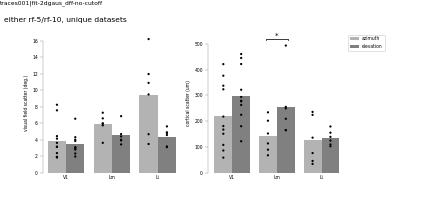

In [483]:
plotd = finaldf0.groupby(['visual_area', 'datakey', 'axis']).mean().reset_index()
print(plotd[['visual_area', 'datakey']]\
      .drop_duplicates().groupby(['visual_area']).count()['datakey'].to_markdown())
s_=[]
fig, axn = pl.subplots(1,2, figsize=(8, 4))
fig.patch.set_facecolor('w')
for ai, metric in enumerate(['deg_scatter', 'dist_scatter']):
    ax=axn[ai]
    sns.barplot(x='visual_area', y=metric, data=plotd, ax=ax,
              order=visual_areas, hue='axis', palette=axis_colors, ci=None)
    sns.stripplot(x='visual_area', y=metric, data=plotd, ax=ax,
              order=visual_areas, hue='axis', dodge=True,
              jitter=False, size=3,
              palette=dict((k, 'k') for k in ['az', 'el']))
    ylabel = 'cortical scatter (um)' if metric=='dist_scatter' \
                else 'visual field scatter (deg.)'
    ax.set_ylabel(ylabel)
    if metric=='dist_scatter':
        offset=20; h=5;
    else:
        offset=1; h=.1;
    # stats
    statdf = pstats.paired_ttests(plotd, metric=metric, c1='az', c2='el',
                                        compare_var='axis', ttest=False)
    statdf['metric'] = metric
    s_.append(statdf)
    pplot.annotate_sig_on_paired_plot(ax, plotd, statdf, metric, offset=offset, h=h)
    ax.legend_.remove()
# custom legend
leg_h = pplot.custom_legend_markers(colors=[axis_colors['az'], axis_colors['el']],
                                   labels=['azimuth', 'elevation'],
                                   marker=None)
ax.legend(handles=leg_h, bbox_to_anchor=(1,1), loc='upper left')

pl.subplots_adjust(left=0.1, right=0.8, wspace=0.2, bottom=0.2, top=0.85)
sns.despine(bottom=True, trim=True)
for ax in axn:
    ax.tick_params(which='both', axis='x', size=0)
    ax.set_xlabel('')

pplot.label_figure(fig, data_id)
fig.text(0.01, 0.9, 'either rf-5/rf-10, unique datasets')
    
figname = 'scatter_perFOV_reliable'
pl.savefig(os.path.join(basedir, '%s.svg' % figname))

In [463]:
exp_colors

{'rfs': [0.7, 0.7, 0.7], 'rfs10': [0.4, 0.4, 0.4]}

In [484]:
passdf['n_cells'] = None
for (va, dk,exp), g in passdf.groupby(['visual_area', 'datakey', 'experiment']):
    passdf.loc[g.index, 'n_cells'] = len(g['cell'].unique())
DF_all = passdf[passdf['n_cells']>min_ncells]

<IPython.core.display.Javascript object>


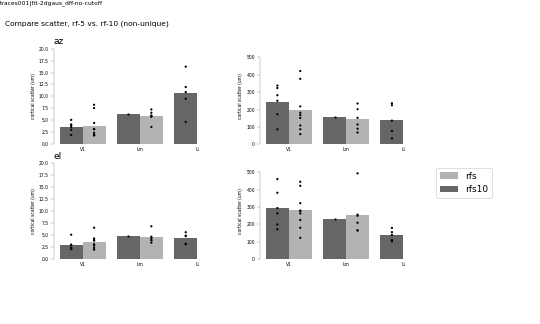

In [487]:
plotd_exp = DF_all.groupby(['visual_area', 'datakey', 'axis', 'experiment'])\
                .mean().reset_index()
# print(plotd[['visual_area', 'datakey']]\
#       .drop_duplicates().groupby(['visual_area']).count()['datakey'].to_markdown())
s_=[]
fig, axn = pl.subplots(2,2, figsize=(10, 6))
fig.patch.set_facecolor('w')
for ei, (exp, exp_df) in enumerate(plotd_exp.groupby('axis')):
    for ai, metric in enumerate(['deg_scatter', 'dist_scatter']):
        ax=axn[ei, ai]
        axn[ei, 0].set_title(exp, loc='left', fontsize=12)
        sns.barplot(x='visual_area', y=metric, data=exp_df, ax=ax,
                  order=visual_areas, hue='experiment', palette=exp_colors, ci=None)
        sns.stripplot(x='visual_area', y=metric, data=exp_df, ax=ax,
                  order=visual_areas, hue='experiment', dodge=True,
                  jitter=False, size=3,
                  palette=dict((k, 'k') for k in ['rfs', 'rfs10']))
        ax.legend_.remove()
#         ylabel = 'cortical scatter (um)' if metric=='dist_scatter' \
#                     else 'visual field scatter (deg.)'
        ax.set_ylabel(ylabel)
        if metric=='dist_scatter':
            offset=20; h=5;
            ax.set_ylim([0, 550])
        else:
            ax.set_ylim([0, 20])
            offset=1; h=.1;
        try:
            # stats
            statdf = pstats.paired_ttests(exp_df, metric=metric, c1='az', c2='el',
                                                compare_var='experiment', ttest=False)
            statdf['metric'] = metric
            s_.append(statdf)
            pplot.annotate_sig_on_paired_plot(ax, exp_df, statdf, 
                                              metric, offset=offset, h=h)
        except Exception as e:
            continue
pl.subplots_adjust(left=0.1, right=0.8, wspace=0.2, bottom=0.2, top=0.85)
sns.despine(bottom=True, trim=True)
for ax in axn.flat:
    ax.tick_params(which='both', axis='x', size=0)
    ax.set_xlabel('')
    #ax.legend_.remove()
# custom legend
leg_h = pplot.custom_legend_markers(colors=[exp_colors['rfs'], exp_colors['rfs10']],
                                   labels=['rfs', 'rfs10'],
                                   marker=None)
axn.flat[-1].legend(handles=leg_h, bbox_to_anchor=(1,1), loc='upper left', fontsize=12)

fig.text(0.01, 0.92, 'Compare scatter, rf-5 vs. rf-10 (non-unique)')


pplot.label_figure(fig, data_id)

figname = 'scatter_compare_rf5-rf10'
pl.savefig(os.path.join(basedir, '%s.svg' % figname))

In [347]:
basedir

'/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/scatter'

In [491]:


fig, axn = pl.subplots(1, 2, figsize=(7,4))
fig.set_facecolor('w')
for ai, (exp, exp_df) in enumerate(plotd_exp.groupby('axis')):
    ax=axn[ai]
    sns.barplot(x='visual_area', y='deviant', data=exp_df,
               hue='experiment', ax=ax, order=visual_areas, palette=exp_colors)
    sns.stripplot(x='visual_area', y='deviant', data=exp_df,
               hue='experiment', ax=ax, order=visual_areas, dodge=True)
    ax.set_title(exp, loc='left')
    
    ax.legend_.remove()
axn[1].legend(bbox_to_anchor=(1,1), loc='upper left')

fig.text(0.01, 0.92, 'Compare deviants, rf-5 vs. rf-10 (non-unique)')
pplot.label_figure(fig, data_id)
pl.subplots_adjust(top=0.8, wspace=0.3)

figname = 'deviants_compare_rfs5-v-rfs10'
pl.savefig(os.path.join(basedir, '%s.svg' % figname))

<IPython.core.display.Javascript object>

In [276]:
importlib.reload(pplot)
%matplotlib inline

In [461]:
# Paired: spstats.wilcoxon()
offset=2
fig, axn = pl.subplots(1,2, figsize=(6.5, 4))
fig.patch.set_facecolor('w')

s_=[]
for ai, metric in enumerate(['deg_scatter', 'dist_scatter']):
    ax=axn[ai]
    ax, pstats = pplot.pairwise_compare_single_metric(plotd, 
                 curr_metric=metric, ax=ax, size=3,
                 c1='az', c2='el', compare_var='axis', 
                 ttest=False, return_stats=True, bar_ci=None)
    pstats['metric'] = metric
    if metric=='dist_scatter':
        offset=20; h=2;
    else:
        offset=1; h=.1;
    pplot.annotate_sig_on_paired_plot(ax, plotd, pstats, metric, offset=offset, h=h)
    s_.append(pstats)
statsdf = pd.concat(s_)
print(statsdf.to_markdown())

pl.subplots_adjust(left=0.1, right=0.9, wspace=0.5, bottom=0.2, top=0.85)

figname = 'scatter_perFOV_paired_reliable'
pl.savefig(os.path.join(basedir, '%s.svg' % figname))

<IPython.core.display.Javascript object>

|    |   t_stat |   p_val | visual_area   | metric       |
|---:|---------:|--------:|:--------------|:-------------|
|  0 |       25 |   0.52  | V1            | deg_scatter  |
|  1 |        3 |   0.156 | Lm            | deg_scatter  |
|  2 |        1 |   0.062 | Li            | deg_scatter  |
|  0 |       11 |   0.054 | V1            | dist_scatter |
|  1 |        0 |   0.031 | Lm            | dist_scatter |
|  2 |       10 |   1     | Li            | dist_scatter |


In [278]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

#perform two-way ANOVA
model = ols('deg_scatter ~ C(visual_area) + C(axis) + C(visual_area):C(axis)', \
            data=plotd).fit()
sm.stats.anova_lm(model, typ=2)


sum_sq    df         F    PR(>F)
C(visual_area)           84.306504   2.0  8.575149  0.000796
C(axis)                  40.132792   1.0  8.164131  0.006749
C(visual_area):C(axis)   43.784254   2.0  4.453470  0.017939
Residual                196.629826  40.0       NaN       NaN

#### deviants

In [294]:
plotd.head()

visual_area              datakey axis        cell  deg_scatter  \
0          Li  20190527_JC092_fov3   az   77.150000     4.687353   
1          Li  20190527_JC092_fov3   el   77.150000     3.202191   
2          Li  20190609_JC099_fov1   az  201.560976    11.985929   
3          Li  20190609_JC099_fov1   el  201.560976     4.831594   
4          Li  20190617_JC099_fov1   az   43.750000    10.916371   

   dist_scatter  reliable   deviant  n_cells  
0     34.318348       1.0  0.150000     40.0  
1    139.308477       1.0  0.150000     40.0  
2    224.639424       1.0  0.414634     41.0  
3    109.798049       1.0  0.414634     41.0  
4     76.525888       1.0  0.437500     16.0

In [295]:

deviant_counts = pd.concat([g for (va, dk, exp), g \
                in countdf.groupby(['visual_area', 'datakey', 'experiment'])\
            if not finaldf.query('@va==visual_area and @dk==datakey and @exp==experiment').empty])

In [296]:
fig, ax = pl.subplots()
exp_colors = {'rfs': [0.7]*3, 'rfs10': [0.4]*3}
sns.stripplot(x='visual_area', y='fraction_deviant', hue='experiment', 
              data=deviant_counts, ax=ax,
             dodge=True, order=visual_areas)
sns.barplot(x='visual_area', y='fraction_deviant', hue='experiment', 
            data=deviant_counts, ax=ax,
             palette=exp_colors, order=visual_areas)

<IPython.core.display.Javascript object>

<AxesSubplot:xlabel='visual_area', ylabel='fraction_deviant'>

In [492]:

dk='20190306_JC061_fov2'
va='Lm'
res = sct.load_gradients(dk, va, retinorun='retino_run1', create_new=True)


Doing gradients


RecursionError: maximum recursion depth exceeded

#### Cortical magnification

In [279]:
import analyze2p.stats as pstats
import statsmodels.api as sm

In [280]:

regr_df = pd.concat([g for (va, dk), g in pass_regr.groupby(['visual_area', 'datakey'])\
                     if not plotd.query('@va==visual_area and @dk==datakey').empty])
print(regr_df[['visual_area', 'datakey']]\
      .drop_duplicates()['visual_area'].value_counts().to_markdown())
regr_df['cortical_mag'] = np.abs(1./regr_df['coefficient'])

|    |   visual_area |
|:---|--------------:|
| V1 |            11 |
| Lm |             6 |
| Li |             6 |


In [281]:
cmag_df = regr_df[['visual_area','datakey']].drop_duplicates().reset_index(drop=True)
cmag_df['cortical_mag'] = None
cmag_df['cortical_mag_ratio'] = None
for (va, dk), cg in cmag_df.groupby(['visual_area', 'datakey']):
    r_df = regr_df[(regr_df.visual_area==va) & (regr_df.datakey==dk)].copy()
    mean_mag = r_df['coefficient'].abs().mean()
    ratio_mag = float(r_df[r_df.cond=='el']['cortical_mag'])\
                /float(r_df[r_df.cond=='az']['cortical_mag'])
    cmag_df.loc[cg.index, 'cortical_mag'] = mean_mag
    cmag_df.loc[cg.index, 'cortical_mag_ratio'] = ratio_mag
cmag_df['cortical_mag'] = abs(cmag_df['cortical_mag'].astype(float))
cmag_df['cortical_mag_ratio'] = abs(cmag_df['cortical_mag_ratio'].astype(float))


In [282]:
%matplotlib notebook

In [284]:
import pingouin as pg

/home/julianarhee/anaconda2/envs/rat2p/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.0, the latest is 0.2.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [286]:
s_=[]
fig, axn = pl.subplots(1,2, figsize=(5,3))
fig.patch.set_facecolor('w')
for ai, metric in enumerate(['cortical_mag', 'cortical_mag_ratio']):
    ax=axn[ai]
    sns.barplot(x='visual_area', y=metric, data=cmag_df, ax=ax,
              order=visual_areas, ci=None, palette=bw_colors)
    sns.stripplot(x='visual_area', y=metric, data=cmag_df, ax=ax,
              order=visual_areas, dodge=True,
              jitter=False, size=3, palette=area_colors)
    stats = pg.pairwise_ttests(dv=metric, between='visual_area', data=cmag_df,
                           subject='datakey', tail='one-sided', # use one-talied bec pos
                           padjust='fdr_bh', parametric=False)
    stats['metric'] = metric
    s_.append(stats)
    ylabel = 'cortical magnification (um/deg)' if ai==0 \
                else 'ratio EL:AZ'
    ax.set_ylabel(ylabel)
statsdf = pd.concat(s_)

sns.despine(bottom=True, trim=True)
for ax in axn:
    ax.tick_params(which='both', axis='x', size=0)
    ax.set_xlabel('')
pl.subplots_adjust(left=0.15, right=0.8, bottom=0.2, top=0.85, wspace=0.5)

pl.savefig(os.path.join(basedir, 'cortical_magnification_reliable.svg'))
print(basedir)

<IPython.core.display.Javascript object>

/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/scatter


In [287]:
statsdf

Contrast   A   B  Paired  Parametric  U-val       Tail     p-unc  \
0  visual_area  Li  Lm   False       False   36.0  one-sided  0.002537   
1  visual_area  Li  V1   False       False   66.0  one-sided  0.000545   
2  visual_area  Lm  V1   False       False   64.0  one-sided  0.001087   
0  visual_area  Li  Lm   False       False   21.0  one-sided  0.344460   
1  visual_area  Li  V1   False       False   52.0  one-sided  0.031491   
2  visual_area  Lm  V1   False       False   63.0  one-sided  0.001514   

     p-corr p-adjust    hedges              metric  
0  0.002537   fdr_bh  1.903121        cortical_mag  
1  0.001631   fdr_bh  4.284866        cortical_mag  
2  0.001631   fdr_bh  2.386670        cortical_mag  
0  0.344460   fdr_bh  0.434381  cortical_mag_ratio  
1  0.047236   fdr_bh  1.295981  cortical_mag_ratio  
2  0.004542   fdr_bh  1.812297  cortical_mag_ratio

<AxesSubplot:xlabel='visual_area', ylabel='deg_scatter'>

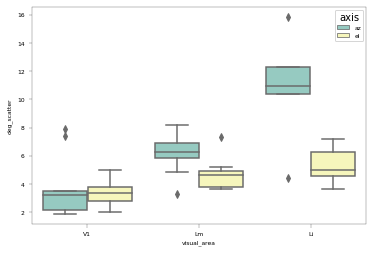

In [127]:
sns.boxplot(x='visual_area', y='deg_scatter', hue='axis', data=plotd, 
            order=visual_areas, palette='Set3')

In [128]:
plotd['subject'] = None
for vi, ((va, dk), g) in enumerate(plotd.groupby(['visual_area','datakey'])):
#     dkeys = list(plotd[plotd.visual_area==va]['datakey'].unique())
#     ix = dkeys.index(dk)
#     print(dk, ix)
    plotd.loc[g.index, 'subject'] = vi

In [129]:
aov_deg = pg.mixed_anova(data=plotd, dv='deg_scatter', between='visual_area',
                     within='axis', subject='subject', effsize='ng2')
aov_deg

Source          SS  DF1  DF2         MS          F     p-unc  \
0  visual_area  154.516727    2   23  77.258364  16.516016  0.000036   
1         axis   35.673000    1   23  35.673000  16.575988  0.000471   
2  Interaction   48.845149    2   23  24.422575  11.348312  0.000373   

        ng2  eps  
0  0.495876  NaN  
1  0.185064  1.0  
2  0.237190  NaN

In [130]:
aov_dist = pg.mixed_anova(data=plotd, dv='dist_scatter', between='visual_area',
                     within='axis', subject='subject', effsize='ng2')
aov_dist

Source             SS  DF1  DF2             MS          F     p-unc  \
0  visual_area   33036.714330    2   23   16518.357165   1.168520  0.328607   
1         axis  109658.546286    1   23  109658.546286  24.689839  0.000050   
2  Interaction    7570.814142    2   23    3785.407071   0.852292  0.439469   

        ng2  eps  
0  0.071769  NaN  
1  0.204228  1.0  
2  0.017410  NaN

In [131]:
# Having calculated the ANOVA, we can now run pairwise T-tests. By default, 
# Pingouin will calculate the within between interaction (in this case, year sex).
metric='deg_scatter'
pg.pairwise_ttests(data=plotd, dv=metric, between='visual_area', 
                   within='axis', subject='subject')

Contrast axis   A   B Paired  Parametric         T        dof  \
0                axis    -  az  el   True        True  3.011395  25.000000   
1         visual_area    -  Li  Lm  False        True  2.165603   4.792596   
2         visual_area    -  Li  V1  False        True  3.837025   4.911267   
3         visual_area    -  Lm  V1  False        True  3.894948  18.830658   
4  axis * visual_area   az  Li  Lm  False        True  2.373711   4.578587   
5  axis * visual_area   az  Li  V1  False        True  3.718771   4.804768   
6  axis * visual_area   az  Lm  V1  False        True  3.500807  18.999999   
7  axis * visual_area   el  Li  Lm  False        True  0.826445   6.929512   
8  axis * visual_area   el  Li  V1  False        True  2.919681   5.317704   
9  axis * visual_area   el  Lm  V1  False        True  3.034144  14.571181   

        Tail     p-unc    BF10    hedges  
0  two-sided  0.005875   7.409  0.607665  
1  two-sided  0.084968   1.758  1.415811  
2  two-sided  0.012581   19.29  2.527366  
3  two-sided  0.000988  30.617  1.598764  
4  two-sided  0.068366   2.224  1.589379  
5  two-sided  0.014754  16.052  2.496410  
6  two-sided  0.002391  15.139  1.417999  
7  two-sided  0.436080   0.569  0.461697  
8  two-sided  0.030692   4.881  1.806415  
9  two-sided  0.008597   6.842  1.335328

In [132]:
# To get the between * within interaction, one can use the within_first argument:
pg.pairwise_ttests(data=plotd, dv=metric, between='visual_area', 
                   within='axis', subject='subject', within_first=False)


Contrast visual_area   A   B Paired  Parametric         T  \
0         visual_area           -  Li  Lm  False        True  2.165603   
1         visual_area           -  Li  V1  False        True  3.837025   
2         visual_area           -  Lm  V1  False        True  3.894948   
3                axis           -  az  el   True        True  3.011395   
4  visual_area * axis          Li  az  el   True        True  3.452505   
5  visual_area * axis          Lm  az  el   True        True  2.887023   
6  visual_area * axis          V1  az  el   True        True  0.412744   

         dof       Tail     p-unc    BF10    hedges  
0   4.792596  two-sided  0.084968   1.758  1.415811  
1   4.911267  two-sided  0.012581   19.29  2.527366  
2  18.830658  two-sided  0.000988  30.617  1.598764  
3  25.000000  two-sided  0.005875   7.409  0.607665  
4   4.000000  two-sided  0.025995   3.541  1.589782  
5   8.000000  two-sided  0.020292   3.644  1.082110  
6  11.000000  two-sided  0.687725   0.309  0.122450

In [133]:
# shapiro-test (should b p>0.05 if noramally distributed)
pg.

#  homogeneity of variance assumption of the between-subject factor (group) 
# can be checked using the Levene’s test
pg. # (homogeneuity of variances if p>0.05)


SyntaxError: invalid syntax (<ipython-input-133-dfeb65c92e4c>, line 2)

In [134]:
k = plotd['visual_area'].nunique()  # Number of groups
n = plotd.shape[0] / k  # Number of observations per group
print(k, n)
achieved_power = pg.power_anova(eta=aov.loc[0, 'ng2'], k=k, n=n, alpha=0.05)
print('Achieved power: %.4f' % achieved_power)

3 17.333333333333332


NameError: name 'aov' is not defined

In [135]:
pg.pairwise_tukey(data=plotd, dv='deg_scatter', between='axis', within='visual_area')


TypeError: pairwise_tukey() got an unexpected keyword argument 'within'

In [136]:
plotd

visual_area              datakey axis        cell  deg_scatter  \
0           Li  20190527_JC092_fov3   az   79.693878     4.436419   
1           Li  20190527_JC092_fov3   el   79.693878     3.665362   
2           Li  20190617_JC099_fov1   az   40.550000    10.956967   
3           Li  20190617_JC099_fov1   el   40.550000     5.012103   
4           Li  20191017_JC113_fov1   az  164.903846    15.875299   
5           Li  20191017_JC113_fov1   el  164.903846     6.286676   
6           Li  20191106_JC120_fov1   az  102.785714    12.314810   
7           Li  20191106_JC120_fov1   el  102.785714     4.552553   
8           Li  20191111_JC120_fov1   az  102.000000    10.372008   
9           Li  20191111_JC120_fov1   el  102.000000     7.199394   
10          Lm  20190430_JC078_fov1   az  123.605263     8.219834   
11          Lm  20190430_JC078_fov1   el  123.605263     4.897407   
12          Lm  20190506_JC080_fov1   az  108.475000     4.847341   
13          Lm  20190506_JC080_fov1   el  108.475000     5.200536   
14          Lm  20190508_JC083_fov1   az  129.253165     6.944721   
15          Lm  20190508_JC083_fov1   el  129.253165     3.794986   
16          Lm  20190512_JC083_fov1   az  164.067797     6.741967   
17          Lm  20190512_JC083_fov1   el  164.067797     7.309655   
18          Lm  20190513_JC078_fov1   az  120.826087     7.755133   
19          Lm  20190513_JC078_fov1   el  120.826087     4.914215   
20          Lm  20190517_JC083_fov1   az  114.416667     5.848481   
21          Lm  20190517_JC083_fov1   el  114.416667     3.676286   
22          Lm  20190525_JC084_fov1   az  113.095238     3.311717   
23          Lm  20190525_JC084_fov1   el  113.095238     3.635747   
24          Lm  20190603_JC080_fov1   az  128.633333     6.202796   
25          Lm  20190603_JC080_fov1   el  128.633333     4.653144   
26          Lm  20190618_JC097_fov1   az  119.500000     6.250805   
27          Lm  20190618_JC097_fov1   el  119.500000     4.565128   
28          V1  20190501_JC076_fov1   az  158.444444     3.320385   
29          V1  20190501_JC076_fov1   el  158.444444     4.536537   
30          V1  20190507_JC083_fov1   az   80.879310     2.189625   
31          V1  20190507_JC083_fov1   el   80.879310     2.642531   
32          V1  20190508_JC083_fov1   az  129.253165     7.422212   
33          V1  20190508_JC083_fov1   el  129.253165     4.996774   
34          V1  20190510_JC083_fov1   az   77.121212     3.491621   
35          V1  20190510_JC083_fov1   el   77.121212     3.495110   
36          V1  20190511_JC083_fov1   az   76.723404     1.901801   
37          V1  20190511_JC083_fov1   el   76.723404     3.083833   
38          V1  20190517_JC083_fov1   az  114.416667     7.874684   
39          V1  20190517_JC083_fov1   el  114.416667     3.728612   
40          V1  20190522_JC084_fov1   az  125.358209     1.861276   
41          V1  20190522_JC084_fov1   el  125.358209     3.168599   
42          V1  20190613_JC097_fov1   az  101.314286     1.969468   
43          V1  20190613_JC097_fov1   el  101.314286     2.388968   
44          V1  20190616_JC097_fov1   az  199.291262     3.235992   
45          V1  20190616_JC097_fov1   el  199.291262     2.857357   
46          V1  20190617_JC097_fov1   az  178.750000     3.148246   
47          V1  20190617_JC097_fov1   el  178.750000     2.002944   
48          V1  20190622_JC085_fov1   az  127.285714     2.844603   
49          V1  20190622_JC085_fov1   el  127.285714     3.676040   
50          V1  20191111_JC117_fov1   az  137.428571     3.536821   
51          V1  20191111_JC117_fov1   el  137.428571     3.864872   

    dist_scatter subject  
0      32.481144       0  
1     159.458303       0  
2      76.810475       1  
3     159.682500       1  
4     230.820891       2  
5     198.714451       2  
6     176.319935       3  
7     150.431881       3  
8     135.870612       4  
9     196.197021       4  
10    110.031237       5  
11    164.813987     

In [317]:
posthocs = pg.pairwise_ttests(dv='deg_scatter', within=['visual_area', 'axis'],
                             subject='datakey', data=plotd)
posthocs

ValueError: Repeated measures dataframe is not balanced. `Subjects` must have the same number of elements in all conditions, even when missing values are present.

In [324]:
pg.sphericity(data=plotd, dv='deg_scatter', subject='datakey', 
              within=['visual_area', 'axis'])[-1]

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/numpy/lib/function_base.py:393: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/core/frame.py:8525: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


LinAlgError: Eigenvalues did not converge